   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  


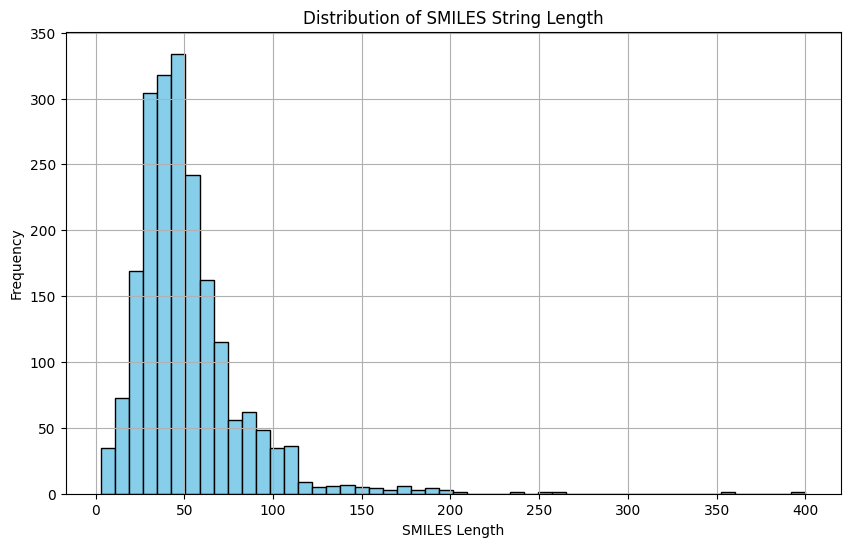

Minimum SMILES Length: 3
Maximum SMILES Length: 400


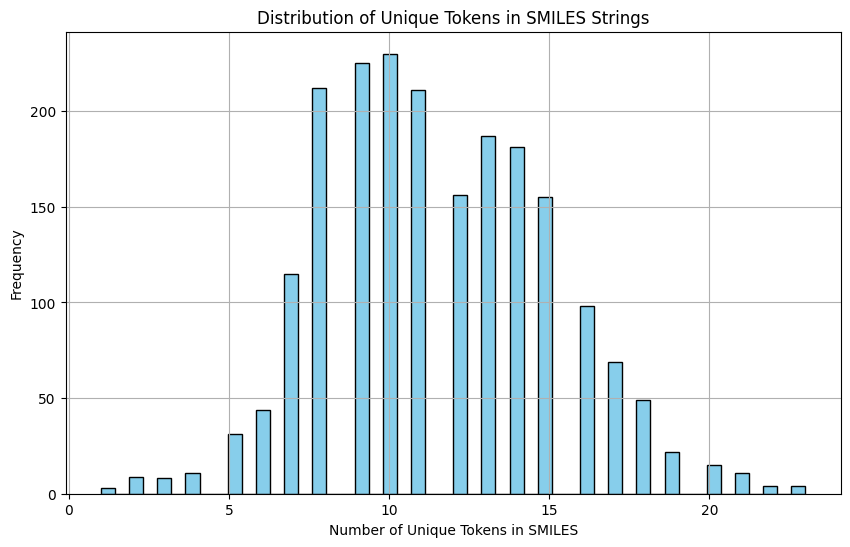

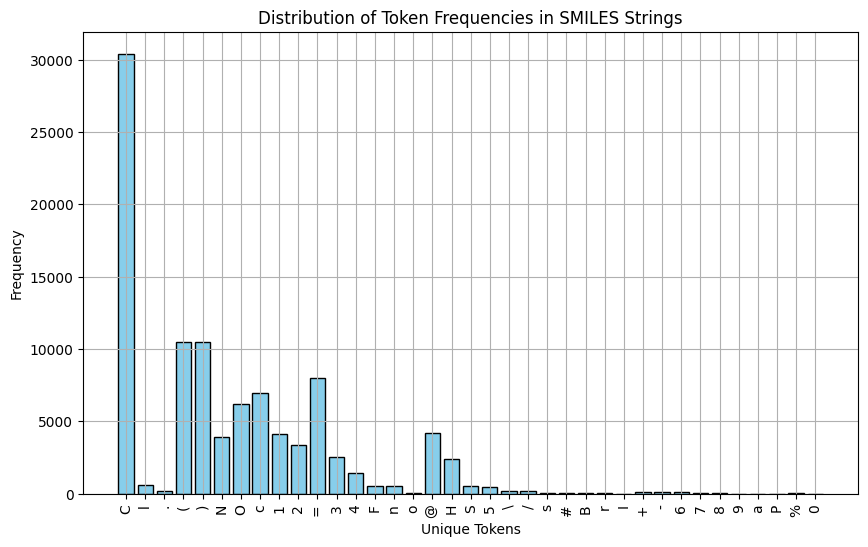

In [1]:
import pandas as pd
from collections import Counter

# Replace 'path_to_csv_file' with the actual path to your BBBP.csv file
path_to_csv_file = '/content/drive/MyDrive/Colab Notebooks/BBBP.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(path_to_csv_file)

# Display the head of the dataset (first few rows)
print(df.head())
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a DataFrame (if not already loaded)
# df = pd.read_csv('path_to_csv_file.csv')

# Tokenize SMILES strings and calculate lengths
df['SMILES_Length'] = df['smiles'].apply(lambda x: len(x))

# Plot the distribution of frequency vs. length
plt.figure(figsize=(10, 6))
plt.hist(df['SMILES_Length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of SMILES String Length')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print min and max length
min_length = df['SMILES_Length'].min()
max_length = df['SMILES_Length'].max()

print(f"Minimum SMILES Length: {min_length}")
print(f"Maximum SMILES Length: {max_length}")

# Calculate the length of each 'smiles' entry and create a new column 'smiles_length'
df['smiles_length'] = df['smiles'].apply(len)
df['unique_tokens'] = df['smiles'].apply(lambda x: len(set(x)))
all_tokens = ''.join(df['smiles']).replace('[', '').replace(']', '').replace(',', '').replace("'", "")
token_counts = pd.Series(list(all_tokens)).value_counts()

# Calculate unique tokens and their frequencies
token_counts = Counter(all_tokens)
unique_tokens = list(token_counts.keys())
token_frequencies = list(token_counts.values())

# Plot the distribution of unique tokens
plt.figure(figsize=(10, 6))
plt.hist(df['unique_tokens'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Unique Tokens in SMILES Strings')
plt.xlabel('Number of Unique Tokens in SMILES')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)
plt.show()

# Plot the distribution of token frequencies
plt.figure(figsize=(10, 6))
plt.bar(unique_tokens, token_frequencies, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Frequencies in SMILES Strings')
plt.xlabel('Unique Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()




In [2]:
unique_chars = set(''.join(df['smiles']))
char_to_index = {char: index for index, char in enumerate(unique_chars)}
import numpy as np

# Function to create one-hot vector for a single character
def char_to_one_hot(char):
    vector = np.zeros(len(unique_chars))
    vector[char_to_index[char]] = 1
    return vector

# Function to create one-hot vector for a SMILES string
def smiles_to_one_hot(smiles):
    return np.concatenate([char_to_one_hot(char) for char in smiles])

df['smiles_one_hot'] = df['smiles'].apply(smiles_to_one_hot)
smiles_one_hot_array = np.array(df['smiles_one_hot'].to_list())
max_length = np.max([len(vector) for vector in smiles_one_hot_array])
padded_vectors = np.array([np.pad(vector, (0, max_length - len(vector))) for vector in smiles_one_hot_array])
one_hot_matrix = np.array(padded_vectors)

<ipython-input-2-a91b31deee5b>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smiles_one_hot_array = np.array(df['smiles_one_hot'].to_list())


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

labels = df['p_np'].values

# Define your model with a single output neuron for binary classification
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output size is 1 for binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Use sigmoid activation for binary classification
        return x

# Convert features and labels to PyTorch tensors
features = torch.tensor(one_hot_matrix, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
    test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = SimpleNN(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Store the AUC score in the list
    auc_scores.append(auc)

    print(f'Fold {fold + 1}, AUC: {auc}')

# Print the AUC scores for all folds
print("AUC Scores for Folds:", auc_scores)
# Calculate the average AUC over 5 folds
average_auc = np.mean(auc_scores)

# Print the average AUC
print("Average AUC over 5 folds:", average_auc)


<ipython-input-10-d48b6c857c64>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-10-d48b6c857c64>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-10-d48b6c857c64>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 1, Epoch 1, Loss: 0.4231172502040863
Fold 1, Epoch 2, Loss: 0.23744025826454163
Fold 1, Epoch 3, Loss: 0.18474705517292023
Fold 1, Epoch 4, Loss: 0.14118322730064392
Fold 1, Epoch 5, Loss: 0.04334484413266182
Fold 1, Epoch 6, Loss: 0.05084171146154404
Fold 1, Epoch 7, Loss: 0.07213559746742249
Fold 1, Epoch 8, Loss: 0.01793072745203972
Fold 1, Epoch 9, Loss: 0.02475566603243351
Fold 1, Epoch 10, Loss: 0.005775381810963154
Fold 1, AUC: 0.9128848195329087


<ipython-input-10-d48b6c857c64>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-10-d48b6c857c64>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 2, Epoch 1, Loss: 0.5581580996513367
Fold 2, Epoch 2, Loss: 0.2970750331878662
Fold 2, Epoch 3, Loss: 0.2387475073337555
Fold 2, Epoch 4, Loss: 0.1146964579820633
Fold 2, Epoch 5, Loss: 0.20394928753376007
Fold 2, Epoch 6, Loss: 0.10856207460165024
Fold 2, Epoch 7, Loss: 0.04437196999788284
Fold 2, Epoch 8, Loss: 0.04245869442820549
Fold 2, Epoch 9, Loss: 0.03736128658056259
Fold 2, Epoch 10, Loss: 0.01736624166369438
Fold 2, AUC: 0.9392250530785563


<ipython-input-10-d48b6c857c64>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-10-d48b6c857c64>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 3, Epoch 1, Loss: 0.5202259421348572
Fold 3, Epoch 2, Loss: 0.2713434100151062
Fold 3, Epoch 3, Loss: 0.32169535756111145
Fold 3, Epoch 4, Loss: 0.15928944945335388
Fold 3, Epoch 5, Loss: 0.1636664718389511
Fold 3, Epoch 6, Loss: 0.0496438592672348
Fold 3, Epoch 7, Loss: 0.09237174689769745
Fold 3, Epoch 8, Loss: 0.03423096984624863
Fold 3, Epoch 9, Loss: 0.02448594942688942
Fold 3, Epoch 10, Loss: 0.012956539168953896
Fold 3, AUC: 0.9228615658245776
Fold 4, Epoch 1, Loss: 0.5207496881484985


<ipython-input-10-d48b6c857c64>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-10-d48b6c857c64>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 4, Epoch 2, Loss: 0.4082867503166199
Fold 4, Epoch 3, Loss: 0.15711364150047302
Fold 4, Epoch 4, Loss: 0.1505754142999649
Fold 4, Epoch 5, Loss: 0.1125556230545044
Fold 4, Epoch 6, Loss: 0.060860056430101395
Fold 4, Epoch 7, Loss: 0.023491907864809036
Fold 4, Epoch 8, Loss: 0.0371042937040329
Fold 4, Epoch 9, Loss: 0.028431233018636703
Fold 4, Epoch 10, Loss: 0.010677071288228035
Fold 4, AUC: 0.9219393300615921


<ipython-input-10-d48b6c857c64>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-10-d48b6c857c64>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 5, Epoch 1, Loss: 0.6313215494155884
Fold 5, Epoch 2, Loss: 0.36667293310165405
Fold 5, Epoch 3, Loss: 0.3400678038597107
Fold 5, Epoch 4, Loss: 0.08636175096035004
Fold 5, Epoch 5, Loss: 0.17063400149345398
Fold 5, Epoch 6, Loss: 0.06525210291147232
Fold 5, Epoch 7, Loss: 0.02280845306813717
Fold 5, Epoch 8, Loss: 0.03163592144846916
Fold 5, Epoch 9, Loss: 0.008569864556193352
Fold 5, Epoch 10, Loss: 0.02619965374469757
Fold 5, AUC: 0.9125522874740623
AUC Scores for Folds: [0.9128848195329087, 0.9392250530785563, 0.9228615658245776, 0.9219393300615921, 0.9125522874740623]
Average AUC over 5 folds: 0.9218926111943393


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Convert features and labels to PyTorch tensors
features = torch.tensor(one_hot_matrix, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
    test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = LSTMModel(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Store the AUC score in the list
    auc_scores.append(auc)

    print(f'Fold {fold + 1}, AUC: {auc}')

# Print the AUC scores for all folds
print("AUC Scores for Folds:", auc_scores)
# Calculate the average AUC over 5 folds
average_auc = np.mean(auc_scores)

# Print the average AUC
print("Average AUC over 5 folds:", average_auc)


<ipython-input-20-a06521417122>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-20-a06521417122>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-20-a06521417122>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 1, Epoch 1, Loss: 0.6257473230361938
Fold 1, Epoch 2, Loss: 0.41383203864097595
Fold 1, Epoch 3, Loss: 0.31828954815864563
Fold 1, Epoch 4, Loss: 0.21325457096099854
Fold 1, Epoch 5, Loss: 0.11460874229669571
Fold 1, Epoch 6, Loss: 0.13225595653057098
Fold 1, Epoch 7, Loss: 0.02916659414768219
Fold 1, Epoch 8, Loss: 0.1108916774392128
Fold 1, Epoch 9, Loss: 0.06316699087619781
Fold 1, Epoch 10, Loss: 0.010068674571812153
Fold 1, AUC: 0.9250597133757962


<ipython-input-20-a06521417122>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)


Fold 2, Epoch 1, Loss: 0.5641299486160278
Fold 2, Epoch 2, Loss: 0.45127567648887634
Fold 2, Epoch 3, Loss: 0.42258787155151367
Fold 2, Epoch 4, Loss: 0.16510462760925293
Fold 2, Epoch 5, Loss: 0.14328762888908386
Fold 2, Epoch 6, Loss: 0.12048821151256561
Fold 2, Epoch 7, Loss: 0.08208735287189484
Fold 2, Epoch 8, Loss: 0.09896478801965714
Fold 2, Epoch 9, Loss: 0.03368081897497177
Fold 2, Epoch 10, Loss: 0.033567436039447784
Fold 2, AUC: 0.9378317409766455


<ipython-input-20-a06521417122>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-20-a06521417122>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 3, Epoch 1, Loss: 0.34678834676742554
Fold 3, Epoch 2, Loss: 0.3165236711502075
Fold 3, Epoch 3, Loss: 0.2974228262901306
Fold 3, Epoch 4, Loss: 0.30055832862854004
Fold 3, Epoch 5, Loss: 0.18154048919677734
Fold 3, Epoch 6, Loss: 0.2816527485847473
Fold 3, Epoch 7, Loss: 0.07699549943208694
Fold 3, Epoch 8, Loss: 0.044055111706256866
Fold 3, Epoch 9, Loss: 0.1317610889673233
Fold 3, Epoch 10, Loss: 0.0663914680480957
Fold 3, AUC: 0.9327756002766707


<ipython-input-20-a06521417122>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-20-a06521417122>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 4, Epoch 1, Loss: 0.4926129877567291
Fold 4, Epoch 2, Loss: 0.6220934391021729
Fold 4, Epoch 3, Loss: 0.3558114469051361
Fold 4, Epoch 4, Loss: 0.2557041049003601
Fold 4, Epoch 5, Loss: 0.261543333530426
Fold 4, Epoch 6, Loss: 0.12562844157218933
Fold 4, Epoch 7, Loss: 0.09676621854305267
Fold 4, Epoch 8, Loss: 0.030103569850325584
Fold 4, Epoch 9, Loss: 0.1406840831041336
Fold 4, Epoch 10, Loss: 0.033560123294591904
Fold 4, AUC: 0.9204901024340436


<ipython-input-20-a06521417122>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-20-a06521417122>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 5, Epoch 1, Loss: 0.6928454637527466
Fold 5, Epoch 2, Loss: 0.4036363959312439
Fold 5, Epoch 3, Loss: 0.3786838948726654
Fold 5, Epoch 4, Loss: 0.3527674973011017
Fold 5, Epoch 5, Loss: 0.26483169198036194
Fold 5, Epoch 6, Loss: 0.1645784080028534
Fold 5, Epoch 7, Loss: 0.07611759006977081
Fold 5, Epoch 8, Loss: 0.08710198104381561
Fold 5, Epoch 9, Loss: 0.05623640865087509
Fold 5, Epoch 10, Loss: 0.024286562576889992
Fold 5, AUC: 0.914067389084681
AUC Scores for Folds: [0.9250597133757962, 0.9378317409766455, 0.9327756002766707, 0.9204901024340436, 0.914067389084681]
Average AUC over 5 folds: 0.9260449092295675


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size1 * 2, hidden_size2)  # Adjusted for bidirectional output
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.bilstm(x)
        # Reshape the output for the fully connected layer
        x = x.reshape(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Convert features and labels to PyTorch tensors
features = torch.tensor(one_hot_matrix, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
    test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the BiLSTM model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = BiLSTMModel(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Store the AUC score in the list
    auc_scores.append(auc)

    print(f'Fold {fold + 1}, AUC: {auc}')

# Print the AUC scores for all folds
print("AUC Scores for Folds:", auc_scores)

# Calculate the average AUC over 5 folds
average_auc = np.mean(auc_scores)

# Print the average AUC
print("Average AUC over 5 folds:",average_auc)


<ipython-input-26-803780b8d4d8>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-26-803780b8d4d8>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-26-803780b8d4d8>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 1, Epoch 1, Loss: 0.5024006962776184
Fold 1, Epoch 2, Loss: 0.39338403940200806
Fold 1, Epoch 3, Loss: 0.3026801347732544
Fold 1, Epoch 4, Loss: 0.11781054735183716
Fold 1, Epoch 5, Loss: 0.1372258961200714
Fold 1, Epoch 6, Loss: 0.042376402765512466
Fold 1, Epoch 7, Loss: 0.042579613626003265
Fold 1, Epoch 8, Loss: 0.0428737998008728
Fold 1, Epoch 9, Loss: 0.008317450061440468
Fold 1, Epoch 10, Loss: 0.012918169610202312


<ipython-input-26-803780b8d4d8>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-26-803780b8d4d8>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 1, AUC: 0.9217423036093418
Fold 2, Epoch 1, Loss: 0.5529919862747192
Fold 2, Epoch 2, Loss: 0.4191713333129883
Fold 2, Epoch 3, Loss: 0.36337727308273315
Fold 2, Epoch 4, Loss: 0.2166001796722412
Fold 2, Epoch 5, Loss: 0.12911584973335266
Fold 2, Epoch 6, Loss: 0.114657923579216
Fold 2, Epoch 7, Loss: 0.039657074958086014
Fold 2, Epoch 8, Loss: 0.02386200986802578
Fold 2, Epoch 9, Loss: 0.01535711158066988
Fold 2, Epoch 10, Loss: 0.019580230116844177
Fold 2, AUC: 0.942011677282378


<ipython-input-26-803780b8d4d8>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-26-803780b8d4d8>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 3, Epoch 1, Loss: 0.5000898838043213
Fold 3, Epoch 2, Loss: 0.35266703367233276
Fold 3, Epoch 3, Loss: 0.2743874192237854
Fold 3, Epoch 4, Loss: 0.23975834250450134
Fold 3, Epoch 5, Loss: 0.107927106320858
Fold 3, Epoch 6, Loss: 0.12059632688760757
Fold 3, Epoch 7, Loss: 0.05123337358236313
Fold 3, Epoch 8, Loss: 0.03129854053258896
Fold 3, Epoch 9, Loss: 0.019217474386096
Fold 3, Epoch 10, Loss: 0.010414350777864456
Fold 3, AUC: 0.9221369520108034


<ipython-input-26-803780b8d4d8>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-26-803780b8d4d8>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 4, Epoch 1, Loss: 0.42132359743118286
Fold 4, Epoch 2, Loss: 0.39001232385635376
Fold 4, Epoch 3, Loss: 0.31716257333755493
Fold 4, Epoch 4, Loss: 0.14071759581565857
Fold 4, Epoch 5, Loss: 0.07773871719837189
Fold 4, Epoch 6, Loss: 0.054551951587200165
Fold 4, Epoch 7, Loss: 0.06270171701908112
Fold 4, Epoch 8, Loss: 0.04195629432797432
Fold 4, Epoch 9, Loss: 0.02607128582894802
Fold 4, Epoch 10, Loss: 0.009663013741374016


<ipython-input-26-803780b8d4d8>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), train_labels)
<ipython-input-26-803780b8d4d8>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), test_labels)


Fold 4, AUC: 0.9263858239188432
Fold 5, Epoch 1, Loss: 0.5404283404350281
Fold 5, Epoch 2, Loss: 0.4403132498264313
Fold 5, Epoch 3, Loss: 0.306744247674942
Fold 5, Epoch 4, Loss: 0.07527408748865128
Fold 5, Epoch 5, Loss: 0.07324445992708206
Fold 5, Epoch 6, Loss: 0.109194315969944
Fold 5, Epoch 7, Loss: 0.07225523889064789
Fold 5, Epoch 8, Loss: 0.031286999583244324
Fold 5, Epoch 9, Loss: 0.09667804837226868
Fold 5, Epoch 10, Loss: 0.018380871042609215
Fold 5, AUC: 0.9121241065841047
AUC Scores for Folds: [0.9217423036093418, 0.942011677282378, 0.9221369520108034, 0.9263858239188432, 0.9121241065841047]
Average AUC over 5 folds: 0.9248801726810942


In [48]:
import pandas as pd

# Define the number of bins
num_bins = 10

# Use pandas qcut function to create equal-sized bins based on SMILES length
df['SMILES_Length_Bin'] = pd.qcut(df['SMILES_Length'], q=num_bins, labels=False)

# Print the counts in each bin
print(df['SMILES_Length_Bin'].value_counts())


3    228
0    219
7    216
2    212
6    209
9    204
5    199
1    194
8    188
4    181
Name: SMILES_Length_Bin, dtype: int64


Fold 1, Epoch 1, Loss: 0.5978525280952454
Fold 1, Epoch 2, Loss: 0.37412387132644653
Fold 1, Epoch 3, Loss: 0.5776280164718628
Fold 1, Epoch 4, Loss: 0.43978434801101685
Fold 1, Epoch 5, Loss: 0.4760495722293854
Fold 1, Epoch 6, Loss: 0.5194351673126221
Fold 1, Epoch 7, Loss: 0.30257290601730347
Fold 1, Epoch 8, Loss: 0.36130380630493164
Fold 1, Epoch 9, Loss: 0.4002346098423004
Fold 1, Epoch 10, Loss: 0.3195320963859558
Fold 1, AUC: 0.8074243630573248
Fold 2, Epoch 1, Loss: 0.44242939352989197
Fold 2, Epoch 2, Loss: 0.4591548442840576
Fold 2, Epoch 3, Loss: 0.28293377161026
Fold 2, Epoch 4, Loss: 0.6145302057266235
Fold 2, Epoch 5, Loss: 0.30668964982032776
Fold 2, Epoch 6, Loss: 0.5130051374435425
Fold 2, Epoch 7, Loss: 0.3936343789100647
Fold 2, Epoch 8, Loss: 0.37977197766304016
Fold 2, Epoch 9, Loss: 0.4197402000427246
Fold 2, Epoch 10, Loss: 0.4933125972747803
Fold 2, AUC: 0.7887473460721868
Fold 3, Epoch 1, Loss: 0.4973889887332916
Fold 3, Epoch 2, Loss: 0.5602859258651733
Fold 

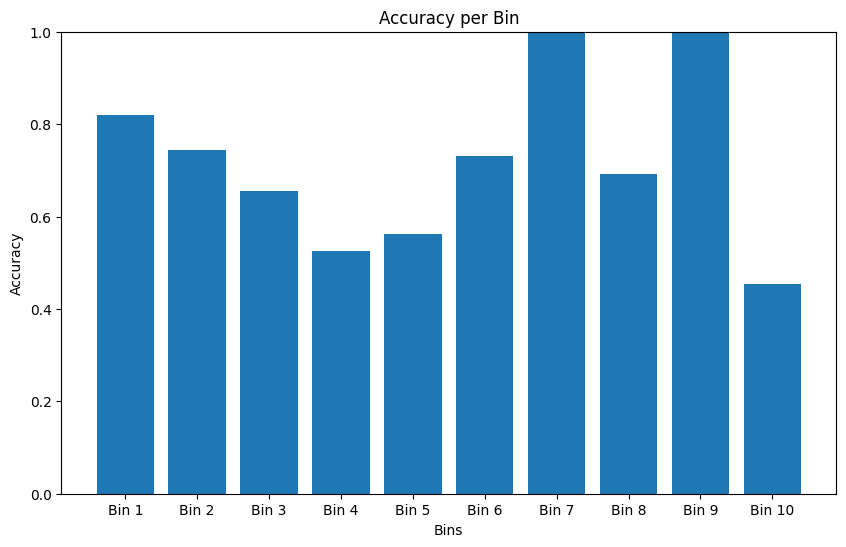

Total Accuracy: 0.74689941618984


In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Define the number of bins
num_bins = 10

# Initialize lists to store AUC scores for each bin
auc_scores_per_bin = [[] for _ in range(num_bins)]

# Initialize lists to store true positive (TP), true negative (TN), false positive (FP), and false negative (FN) counts for each bin
TP_counts_per_bin = [0] * num_bins
TN_counts_per_bin = [0] * num_bins
FP_counts_per_bin = [0] * num_bins
FN_counts_per_bin = [0] * num_bins

# Cross-validation loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = SimpleNN(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Determine the bin for the current test data
    bin_indices = pd.cut(df.iloc[test_index]['SMILES_Length'], bins=num_bins, labels=False)

    # Store the AUC score in the respective bin's list
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        auc_scores_per_bin[i].append(auc_scores_per_bin[i] + [auc] if bin_mask.any() else [])

    print(f'Fold {fold + 1}, AUC: {auc}')

    # Apply threshold for binary classification
    threshold = 0.5

    # Compare predictions to true labels and update TP, TN, FP, FN counts for each bin
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_predictions = (np.array(test_outputs)[bin_mask] > threshold).astype(int)
        bin_true_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_true_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_true_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_true_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_true_labels == 1))

        TP_counts_per_bin[i] += TP
        TN_counts_per_bin[i] += TN
        FP_counts_per_bin[i] += FP
        FN_counts_per_bin[i] += FN

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)
    print(f'Bin {i+1} Accuracy:', accuracy)

import matplotlib.pyplot as plt

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)

# Plot accuracy for each bin
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_bins+1), accuracy_per_bin, tick_label=[f'Bin {i+1}' for i in range(num_bins)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1 for accuracy
plt.show()


# Calculate total TP, TN, FP, and FN counts
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)

# Calculate total accuracy
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples

print("Total Accuracy:", total_accuracy)


Fold 1, Epoch 1, Loss: 0.6811363101005554
Fold 1, Epoch 2, Loss: 0.3961944878101349
Fold 1, Epoch 3, Loss: 0.5071949362754822
Fold 1, Epoch 4, Loss: 0.550753653049469
Fold 1, Epoch 5, Loss: 0.4615466594696045
Fold 1, Epoch 6, Loss: 0.6004586219787598
Fold 1, Epoch 7, Loss: 0.5228266716003418
Fold 1, Epoch 8, Loss: 0.46242809295654297
Fold 1, Epoch 9, Loss: 0.5584942102432251
Fold 1, Epoch 10, Loss: 0.45646601915359497
Fold 1, AUC: 0.7255506900212314
Fold 2, Epoch 1, Loss: 0.589709460735321
Fold 2, Epoch 2, Loss: 0.5541909337043762
Fold 2, Epoch 3, Loss: 0.46341046690940857
Fold 2, Epoch 4, Loss: 0.45565614104270935
Fold 2, Epoch 5, Loss: 0.5119324326515198
Fold 2, Epoch 6, Loss: 0.4063364565372467
Fold 2, Epoch 7, Loss: 0.5559092164039612
Fold 2, Epoch 8, Loss: 0.5733038783073425
Fold 2, Epoch 9, Loss: 0.617534339427948
Fold 2, Epoch 10, Loss: 0.4768628478050232
Fold 2, AUC: 0.7237592887473461
Fold 3, Epoch 1, Loss: 0.5021225214004517
Fold 3, Epoch 2, Loss: 0.4157803952693939
Fold 3, E

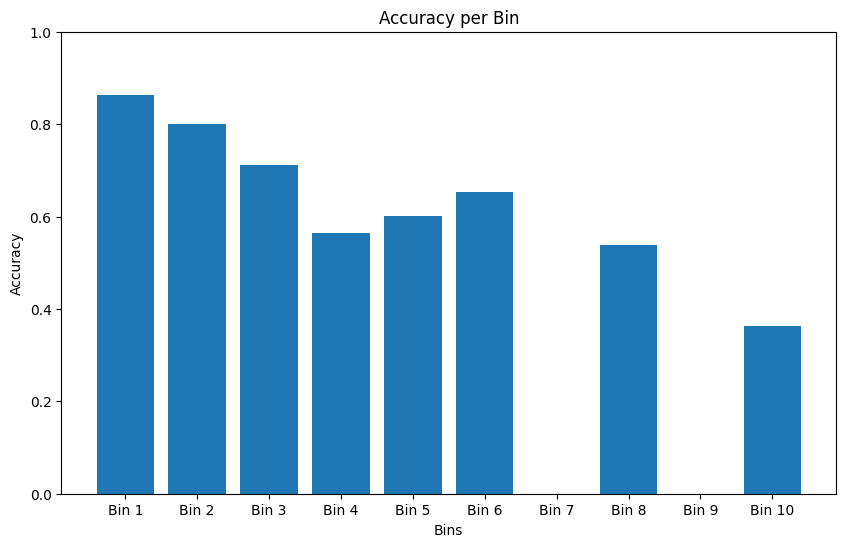

Total Accuracy: 0.8009345319352871


In [53]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Define the number of bins
num_bins = 10

# Initialize lists to store AUC scores for each bin
auc_scores_per_bin = [[] for _ in range(num_bins)]

# Initialize lists to store true positive (TP), true negative (TN), false positive (FP), and false negative (FN) counts for each bin
TP_counts_per_bin = [0] * num_bins
TN_counts_per_bin = [0] * num_bins
FP_counts_per_bin = [0] * num_bins
FN_counts_per_bin = [0] * num_bins

# Cross-validation loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = LSTMModel(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Determine the bin for the current test data
    bin_indices = pd.cut(df.iloc[test_index]['SMILES_Length'], bins=num_bins, labels=False)

    # Store the AUC score in the respective bin's list
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        auc_scores_per_bin[i].append(auc_scores_per_bin[i] + [auc] if bin_mask.any() else [])

    print(f'Fold {fold + 1}, AUC: {auc}')

    # Apply threshold for binary classification
    threshold = 0.5

    # Compare predictions to true labels and update TP, TN, FP, FN counts for each bin
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_predictions = (np.array(test_outputs)[bin_mask] > threshold).astype(int)
        bin_true_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_true_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_true_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_true_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_true_labels == 1))

        TP_counts_per_bin[i] += TP
        TN_counts_per_bin[i] += TN
        FP_counts_per_bin[i] += FP
        FN_counts_per_bin[i] += FN

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)
    print(f'Bin {i+1} Accuracy:', accuracy)

import matplotlib.pyplot as plt

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)

# Plot accuracy for each bin
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_bins+1), accuracy_per_bin, tick_label=[f'Bin {i+1}' for i in range(num_bins)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1 for accuracy
plt.show()


# Calculate total TP, TN, FP, and FN counts
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)

# Calculate total accuracy
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples

print("Total Accuracy:", total_accuracy)


Fold 1, Epoch 1, Loss: 0.5370784997940063
Fold 1, Epoch 2, Loss: 0.3741631507873535
Fold 1, Epoch 3, Loss: 0.5643978714942932
Fold 1, Epoch 4, Loss: 0.49996551871299744
Fold 1, Epoch 5, Loss: 0.4267714023590088
Fold 1, Epoch 6, Loss: 0.4030700623989105
Fold 1, Epoch 7, Loss: 0.39849767088890076
Fold 1, Epoch 8, Loss: 0.5624127388000488
Fold 1, Epoch 9, Loss: 0.68352872133255
Fold 1, Epoch 10, Loss: 0.5387040376663208
Fold 1, AUC: 0.7251857749469215
Fold 2, Epoch 1, Loss: 0.6478980779647827
Fold 2, Epoch 2, Loss: 0.48132896423339844
Fold 2, Epoch 3, Loss: 0.400517076253891
Fold 2, Epoch 4, Loss: 0.49671316146850586
Fold 2, Epoch 5, Loss: 0.4377680718898773
Fold 2, Epoch 6, Loss: 0.5520259141921997
Fold 2, Epoch 7, Loss: 0.516863226890564
Fold 2, Epoch 8, Loss: 0.4979217052459717
Fold 2, Epoch 9, Loss: 0.4871262013912201
Fold 2, Epoch 10, Loss: 0.48194456100463867
Fold 2, AUC: 0.7371616242038217
Fold 3, Epoch 1, Loss: 0.5476829409599304
Fold 3, Epoch 2, Loss: 0.5422447323799133
Fold 3, E

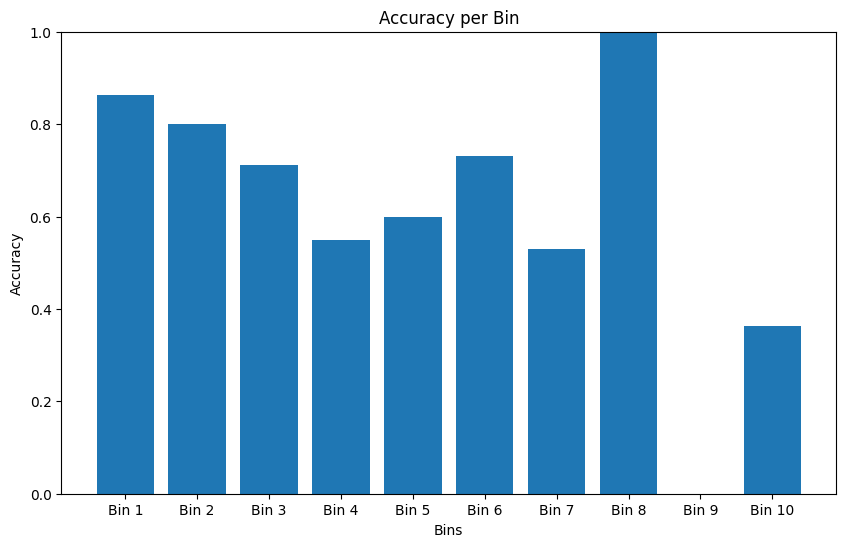

Total Accuracy: 0.8007203229835314


In [54]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Define the number of bins
num_bins = 10

# Initialize lists to store AUC scores for each bin
auc_scores_per_bin = [[] for _ in range(num_bins)]

# Initialize lists to store true positive (TP), true negative (TN), false positive (FP), and false negative (FN) counts for each bin
TP_counts_per_bin = [0] * num_bins
TN_counts_per_bin = [0] * num_bins
FP_counts_per_bin = [0] * num_bins
FN_counts_per_bin = [0] * num_bins

# Cross-validation loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(features, labels)):
    # Split data into train and test sets for the current fold
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Add an extra dimension to target labels
    train_labels = train_labels.unsqueeze(1)
    test_labels = test_labels.unsqueeze(1)

    # Convert train and test data to PyTorch tensors
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    # Create DataLoaders for train and test data
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model for each fold
    input_size = train_features.shape[1]  # Assuming input size is the number of features
    hidden_size1 = 64  # Adjust as needed
    hidden_size2 = 32  # Adjust as needed
    model = BiLSTMModel(input_size, hidden_size1, hidden_size2)

    # Define the loss function (Binary Cross-Entropy) and optimizer (Adam)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop for each epoch
    for epoch in range(10):
        # Set the model to training mode
        model.train()

        # Iterate over the training data in batches
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print training loss for every epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {loss.item()}')

    # Set the model to evaluation mode
    model.eval()
    test_outputs = []

    # Evaluate the model on the test data
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())

    # Calculate AUC score for the fold
    auc = roc_auc_score(test_labels, np.array(test_outputs))

    # Determine the bin for the current test data
    bin_indices = pd.cut(df.iloc[test_index]['SMILES_Length'], bins=num_bins, labels=False)

    # Store the AUC score in the respective bin's list
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        auc_scores_per_bin[i].append(auc_scores_per_bin[i] + [auc] if bin_mask.any() else [])

    print(f'Fold {fold + 1}, AUC: {auc}')

    # Apply threshold for binary classification
    threshold = 0.5

    # Compare predictions to true labels and update TP, TN, FP, FN counts for each bin
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_predictions = (np.array(test_outputs)[bin_mask] > threshold).astype(int)
        bin_true_labels = np.array(test_labels)[bin_mask].squeeze()

        TP = np.sum((bin_predictions == 1) & (bin_true_labels == 1))
        TN = np.sum((bin_predictions == 0) & (bin_true_labels == 0))
        FP = np.sum((bin_predictions == 1) & (bin_true_labels == 0))
        FN = np.sum((bin_predictions == 0) & (bin_true_labels == 1))

        TP_counts_per_bin[i] += TP
        TN_counts_per_bin[i] += TN
        FP_counts_per_bin[i] += FP
        FN_counts_per_bin[i] += FN

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)
    print(f'Bin {i+1} Accuracy:', accuracy)

import matplotlib.pyplot as plt

# Calculate accuracy for each bin
accuracy_per_bin = []
for i in range(num_bins):
    total_samples = TP_counts_per_bin[i] + TN_counts_per_bin[i] + FP_counts_per_bin[i] + FN_counts_per_bin[i]
    accuracy = (TP_counts_per_bin[i] + TN_counts_per_bin[i]) / total_samples
    accuracy_per_bin.append(accuracy)

# Plot accuracy for each bin
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_bins+1), accuracy_per_bin, tick_label=[f'Bin {i+1}' for i in range(num_bins)])
plt.xlabel('Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy per Bin')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1 for accuracy
plt.show()

# Calculate total TP, TN, FP, and FN counts
total_TP = sum(TP_counts_per_bin)
total_TN = sum(TN_counts_per_bin)
total_FP = sum(FP_counts_per_bin)
total_FN = sum(FN_counts_per_bin)

# Calculate total accuracy
total_samples = total_TP + total_TN + total_FP + total_FN
total_accuracy = (total_TP + total_TN) / total_samples

print("Total Accuracy:", total_accuracy)
